# Proyecto Final

## Generacion de Arte

#### Manuel Rodas 21509
#### Sebastian Solorzano 
#### Jose Santisteban

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.mixed_precision import set_global_policy # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt

In [17]:
# Configuración
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 1000
BATCH_SIZE = 32
DATASET_PATH = './NORMAL'

In [18]:
def load_images(dataset_path):
    images = []
    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        try:
            # Intentar cargar la imagen
            img = load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = (img_array - 127.5) / 127.5  # Normalizar a rango [-1, 1]
            images.append(img_array)
        except UnidentifiedImageError:
            print(f"Advertencia: No se pudo identificar el archivo {file_path}. Se omitirá.")
        except Exception as e:
            print(f"Error al procesar el archivo {file_path}: {e}")
    return np.array(images)

images = load_images(DATASET_PATH)[:800]

In [19]:
def build_generator():
    model = tf.keras.Sequential([
        Dense(8 * 8 * 256, input_dim=LATENT_DIM),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((8, 8, 256)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(IMG_CHANNELS, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model

In [20]:
# Creación del Discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
               kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.3),
        Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [21]:
# Construcción de las redes
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0004, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\jsken\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jsken\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Creación del modelo combinado
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(LATENT_DIM,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0001, 0.5), loss='binary_crossentropy')

In [23]:
def save_and_plot_generated_images(epoch, generator, examples=5):
    noise = np.random.normal(0, 1, (examples, LATENT_DIM))
    generated_images = generator.predict(noise)
    
    # Escalar de [-1, 1] a [0, 1]
    generated_images = 0.5 * generated_images + 0.5  # Escalar a [0, 1]
    
    # Asegurarse de que las imágenes estén en el tipo correcto
    generated_images = np.clip(generated_images, 0.0, 1.0)  # Limitar los valores entre 0 y 1
    generated_images = (generated_images * 255).astype(np.uint8)  # Convertir a uint8

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(generated_images):
        plt.subplot(1, examples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()

In [24]:
# Entrenamiento de la GAN
def train_gan(epochs, batch_size):
    real_labels = np.random.uniform(0.7, 1.2, (batch_size, 1))
    fake_labels = np.random.uniform(0.0, 0.3, (batch_size, 1))

    
    for epoch in range(epochs):
        # Entrenar el discriminador
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]

        if real_images.shape[0] != batch_size:
            continue  # Saltar iteración si no hay suficientes datos

        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM)).astype(np.float32)
        fake_images = generator.predict(noise)
        
        discriminator.trainable = True
        for _ in range(2):  # Entrena el discriminador más veces
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, real_labels)
        
        # Mostrar progreso
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, D Acc: {d_loss[1]}, G Loss: {g_loss}")
        
        # Guardar e imprimir imágenes cada 1000 épocas
        if epoch % 100 == 0 and epoch > 0:
            save_and_plot_generated_images(epoch, generator)

In [25]:
print(f"Dataset shape: {images.shape}")
print(f"Min pixel value: {np.min(images)}, Max pixel value: {np.max(images)}")

Dataset shape: (800, 64, 64, 3)
Min pixel value: -1.0, Max pixel value: 1.0


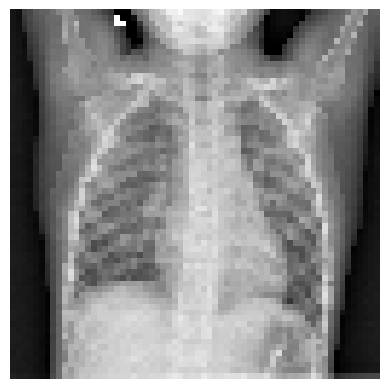

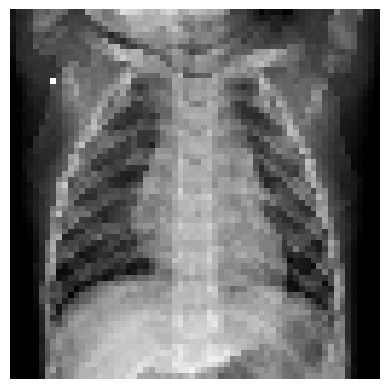

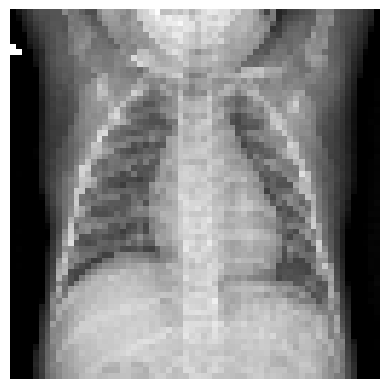

In [26]:
import matplotlib.pyplot as plt
for i in range(3):
    plt.imshow((images[i] + 1) / 2)  # Convertir de rango [-1, 1] a [0, 1]
    plt.axis('off')
    plt.show()

In [27]:
# Entrenar la GAN
train_gan(EPOCHS, BATCH_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Epoch 0, D Loss: 0.9740929007530212, D Acc: 0.0, G Loss: [array(0.90932274, dtype=float32), array(0.90932274, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


DecodeError: Error parsing message